In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [3]:
with open('../data/Korean_movie_reviews_2016_small.txt', encoding='utf-8') as f:
    docs = [doc.strip().split('\t') for doc in f ]
    docs = [(doc[0], int(doc[1])) for doc in docs if len(doc) == 2]
    texts, labels = zip(*docs)

In [4]:
len(texts)

29875

In [5]:
from transformers import BertTokenizer, TFAlbertForSequenceClassification

In [6]:
tokenizer= BertTokenizer.from_pretrained("kykim/albert-kor-base")

C:\Users\yong\anaconda3\envs\textmining_cpu\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\yong\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [7]:
from tensorflow.keras.utils import to_categorical
y_one_hot = to_categorical(labels)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(texts, y_one_hot, test_size=0.2, random_state=0)

In [9]:
len(X_train)

23900

In [10]:
X_train_tokenized = tokenizer(X_train, return_tensors="np", max_length=30, padding='max_length', truncation=True)
X_test_tokenized = tokenizer(X_test, return_tensors="np", max_length=30, padding='max_length', truncation=True)

In [11]:
model = TFAlbertForSequenceClassification.from_pretrained("kykim/albert-kor-base", num_labels=2, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertForSequenceClassification: ['albert.embeddings.position_ids', 'sop_classifier.classifier.bias', 'sop_classifier.classifier.weight']
- This IS expected if you are initializing TFAlbertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [12]:
optimizer = tf.keras.optimizers.Adam(2e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
checkpoint_filepath = "./checkpoints/checkpoint_albert_kr"
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', 
                     save_best_only=True, save_weights_only=True)

In [14]:
history = model.fit(dict(X_train_tokenized), y_train, epochs=10, batch_size=128, 
                    validation_split=0.1, callbacks=[es, mc])

Epoch 1/10
169/169 [==============================] - 969s 6s/step - loss: 0.4099 - accuracy: 0.8126 - val_loss: 0.3121 - val_accuracy: 0.8669
Epoch 2/10
169/169 [==============================] - 941s 6s/step - loss: 0.2554 - accuracy: 0.8966 - val_loss: 0.2965 - val_accuracy: 0.8833
Epoch 3/10
169/169 [==============================] - 914s 5s/step - loss: 0.1919 - accuracy: 0.9278 - val_loss: 0.3195 - val_accuracy: 0.8787
Epoch 4/10
169/169 [==============================] - 916s 5s/step - loss: 0.1363 - accuracy: 0.9502 - val_loss: 0.3490 - val_accuracy: 0.8833
Epoch 5/10
169/169 [==============================] - 910s 5s/step - loss: 0.0938 - accuracy: 0.9702 - val_loss: 0.4029 - val_accuracy: 0.8782
Epoch 5: early stopping


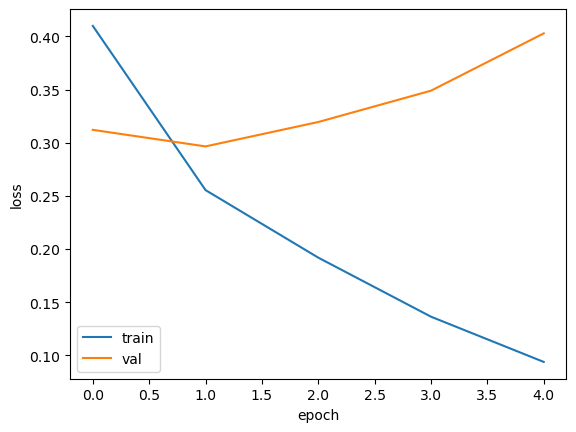

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

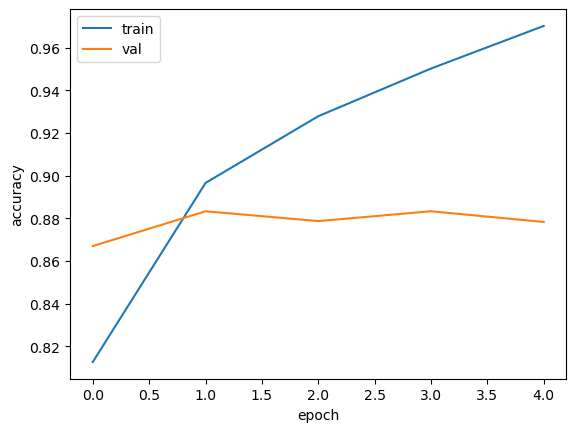

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

In [17]:
model.load_weights(checkpoint_filepath)
model.evaluate(dict(X_test_tokenized), np.array(y_test))

187/187 [==============================] - 87s 465ms/step - loss: 0.2703 - accuracy: 0.8931


[0.2703113853931427, 0.8930543661117554]

In [18]:
y_preds = model.predict(dict(X_test_tokenized))
prediction_probs = tf.nn.softmax(y_preds.logits,axis=1).numpy()
y_predictions = np.argmax(prediction_probs, axis=1)
y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_predictions, y_test))

187/187 [==============================] - 91s 478ms/step
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      2960
           1       0.88      0.91      0.90      3015

    accuracy                           0.89      5975
   macro avg       0.89      0.89      0.89      5975
weighted avg       0.89      0.89      0.89      5975

